In [ ]:
# import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import re
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ast
from PIL import Image, ImageDraw
import cv2


## Create Necessary Functions for Script

In [2]:
# Function to read in Marks
def read_xml(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    return lines

In [3]:
# Plotting Function
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

In [4]:
# Function to parse marks

def parse_mark(mark):
    i = 0
    t = 0
    test_1 = re.findall(r'\d+', mark)
    dims = len(test_1)//2
    temp = np.empty([dims, 2])
    
    while i < dims:
        temp[i] = (test_1[t], test_1[t+1])
        i = i+1
        t = t+2
    
    temp = temp.astype(int)   
    return temp


## Import Data and Create Marks/Bounding Boxes for Images

In [5]:
# Get a list of files in Thyroid with Segmentatin Coordinates
filenames = glob.glob("thyroid/*")

In [6]:
# Create List of Images Files
images = [x for x in filenames if x.endswith(".jpg")]

# Create List of Segments
segments = [x for x in filenames if x.endswith(".xml")]

In [7]:
# Create List of Marks
marks = [read_xml(file) for file in segments]

In [8]:
# Initialize a dictionary
temp_dict = {}

# Create a dictionary with img_id as the Key and the Mark as the Values
for i in marks:
    pattern = r"<case>(.*?)</case>"
    temp = re.findall(pattern, str(i))[0]
    
    id_1 = re.findall(r"<number>(.*?)</number>",temp)[0]
    id_2 = re.findall(r"<image>(.*?)</image>",temp)
    
    for t in id_2:
        pattern = r"<image>"+t+"</image><svg>(.*?)</svg>"
        temp_dict[id_1+'_'+t] = re.findall(pattern,temp)

In [9]:
# Create DataFrame from Dictionary
segments = pd.DataFrame.from_dict(temp_dict, orient='index').reset_index()

# Rename columns
segments = segments.rename(columns = {'index':'img_id',0:"mark"})

# Look at df
segments.head()


,img_id,mark
0,162_1,"[{""points"": [{""x"": 403, ""y"": 79}, {""x"": 399, ""..."
1,88_1,"[{""points"": [{""x"": 274, ""y"": 45}, {""x"": 254, ""..."
2,88_2,"[{""points"": [{""x"": 395, ""y"": 65}, {""x"": 391, ""..."
3,176_1,"[{""points"": [{""x"": 220, ""y"": 169}, {""x"": 227, ..."
4,63_1,"[{""points"": [{""x"": 216, ""y"": 123}, {""x"": 218, ..."


In [10]:
# Remove images without a mark
segments = segments[segments['mark']!=""]

In [11]:
# add file path to image id
segments['img_id'] = segments["img_id"].apply(lambda x: "thyroid/"+x+".jpg")

In [13]:
# Remove images in which the data does not make sense
pattern = r'"points"(.*?)"annotation"'
segments = segments[segments["mark"].apply(lambda x: len(re.findall(pattern, x))<=2)]

### Test Plotting

In [14]:
# Prepare data for test plot - If marks have not yet been parsed

test = segments.loc[segments['img_id']=="thyroid/202_1.jpg"]
l = test['mark'].get_values()[0]

i = 0
t = 0

test_1 = re.findall(r'\d+', l)

dims = len(test_1)//2

coords = np.empty([dims, 2])

while i < dims:
    coords[i] = (test_1[t], test_1[t+1])
    i = i+1
    t = t+2


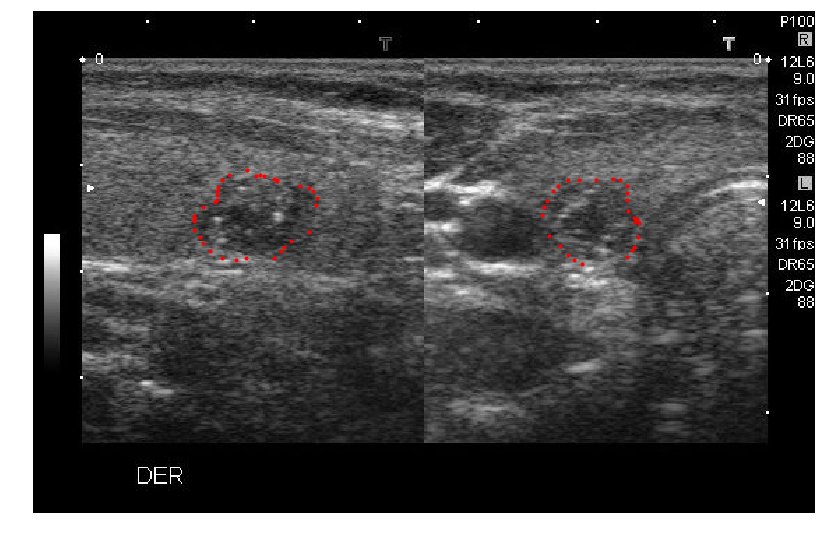

In [16]:
# Create Plot

# If already parsed. If not, comment out the following line of code
coords = segments.loc[segments['img_id']=="thyroid/202_1.jpg"].mark.get_values()[0]

fig, ax = image_show(Image.open('thyroid/202_1.jpg'), cmap='gray')
ax.plot(coords[:, 0], coords[:, 1], '.r',lw=3)

In [17]:
# Break up Marks
pattern = r'"points"(.*?)"annotation"'
segments["mark_1"] = segments["mark"].apply(lambda x: re.findall(pattern, x)[0])
segments["mark_2"] = segments["mark"].apply(lambda x: re.findall(pattern, x)[1] if len(re.findall(pattern, x)) > 1 else "")

In [18]:
segments.head()

,img_id,mark,mark_1,mark_2
0,thyroid/162_1.jpg,"[{""points"": [{""x"": 403, ""y"": 79}, {""x"": 399, ""...",": [{""x"": 403, ""y"": 79}, {""x"": 399, ""y"": 79}, {...",": [{""x"": 217, ""y"": 108}, {""x"": 216, ""y"": 96}, ..."
1,thyroid/88_1.jpg,"[{""points"": [{""x"": 274, ""y"": 45}, {""x"": 254, ""...",": [{""x"": 274, ""y"": 45}, {""x"": 254, ""y"": 47}, {...",
2,thyroid/88_2.jpg,"[{""points"": [{""x"": 395, ""y"": 65}, {""x"": 391, ""...",": [{""x"": 395, ""y"": 65}, {""x"": 391, ""y"": 58}, {...",
3,thyroid/176_1.jpg,"[{""points"": [{""x"": 220, ""y"": 169}, {""x"": 227, ...",": [{""x"": 220, ""y"": 169}, {""x"": 227, ""y"": 161},...",
4,thyroid/63_1.jpg,"[{""points"": [{""x"": 216, ""y"": 123}, {""x"": 218, ...",": [{""x"": 216, ""y"": 123}, {""x"": 218, ""y"": 119},...",": [{""x"": 443, ""y"": 161}, {""x"": 448, ""y"": 156},..."


In [19]:
# Remove observations in which images are poorly marked
segments = segments[~segments.img_id.str.contains('384_1')]
segments = segments[~segments.img_id.str.contains('338_2')]

# Remove secondary marks that were accidental
segments.loc[452, 'mark_2'] = "" # 378_1
segments.loc[115, 'mark_2'] = "" # 358_1
segments.loc[46, 'mark_2'] = "" # 362_1
segments.loc[69, 'mark_2'] = "" # 399_1

In [20]:
# After cleaning, revert back to mark
segments['mark'] = segments.loc[:,'mark_1']+segments.loc[:,'mark_2']

In [21]:
# Parse Marks
segments['mark'] = segments['mark'].apply(lambda x: parse_mark(x))
segments['mark_1'] = segments['mark_1'].apply(lambda x: parse_mark(x))
segments['mark_2'] = segments['mark_2'].apply(lambda x: parse_mark(x) if x != "" else "")

In [22]:
segments.head()

,img_id,mark,mark_1,mark_2
0,thyroid/162_1.jpg,"[[403, 79], [399, 79], [391, 78], [379, 82], [...","[[403, 79], [399, 79], [391, 78], [379, 82], [...","[[217, 108], [216, 96], [210, 92], [199, 92], ..."
1,thyroid/88_1.jpg,"[[274, 45], [254, 47], [239, 50], [221, 51], [...","[[274, 45], [254, 47], [239, 50], [221, 51], [...",
2,thyroid/88_2.jpg,"[[395, 65], [391, 58], [387, 51], [383, 48], [...","[[395, 65], [391, 58], [387, 51], [383, 48], [...",
3,thyroid/176_1.jpg,"[[220, 169], [227, 161], [253, 147], [256, 141...","[[220, 169], [227, 161], [253, 147], [256, 141...",
4,thyroid/63_1.jpg,"[[216, 123], [218, 119], [219, 110], [207, 108...","[[216, 123], [218, 119], [219, 110], [207, 108...","[[443, 161], [448, 156], [461, 154], [469, 154..."


In [28]:
#Create new df and add a name column
df = segments[['img_id','mark_1','mark_2']].copy()
df['name'] = df['img_id'].apply(lambda x: x.replace('thyroid/','').replace('.jpg',''))
df.index = range(len(df))

In [29]:
df.head()

,img_id,mark_1,mark_2,name
0,thyroid/162_1.jpg,"[[403, 79], [399, 79], [391, 78], [379, 82], [...","[[217, 108], [216, 96], [210, 92], [199, 92], ...",162_1
1,thyroid/88_1.jpg,"[[274, 45], [254, 47], [239, 50], [221, 51], [...",,88_1
2,thyroid/88_2.jpg,"[[395, 65], [391, 58], [387, 51], [383, 48], [...",,88_2
3,thyroid/176_1.jpg,"[[220, 169], [227, 161], [253, 147], [256, 141...",,176_1
4,thyroid/63_1.jpg,"[[216, 123], [218, 119], [219, 110], [207, 108...","[[443, 161], [448, 156], [461, 154], [469, 154...",63_1


In [30]:
# Build masked Images and save originals and mask to designated path

for i in range(df.shape[0]):
    
    # Create variables for coords and initialize two lists
    seg_coord_1 = df.loc[i,'mark_1']
    seg_coord_2 = df.loc[i,'mark_2']
    lis_1 = []
    lis_2 = []
    
    # Add mark 1 coords to lis_1
    for coord in seg_coord_1:
        lis_1.append(coord[0])
        lis_1.append(coord[1])
    
    # Add mark 2 coords to lis_2
    for coord in seg_coord_2:
        lis_2.append(coord[0])
        lis_2.append(coord[1])
        
    polygon_1 = lis_1
    polygon_2 = lis_2
    
    # Grab the original image size to ensure that the generated mask is the same size 
    image = cv2.imread(df.loc[i,'img_id'])
    size = image.shape

    # Create mask image and draw the first mark
    img = Image.new('L', (size[1], size[0]), 255)
    ImageDraw.Draw(img).polygon(polygon_1, outline=1, fill=1)
    
    # If the mask has additional masks, add to mask
    if len(polygon_2) > 0:
        ImageDraw.Draw(img).polygon(polygon_2, outline=1, fill=1)
    mask = np.array(img)
    
    # Write masks to "./data/train/label/"
    basepath = "./data/train/label/"
    cv2.imwrite(basepath+df.loc[i,"name"]+".png",mask)
    
    # Write Original Images to "./data/train/image/"
    cv2.imwrite("./data/train/image/"+df.loc[i,"name"]+".png",image)
    

In [34]:
# Add image path and mask path to df. We will save this info as a csv for reference 
df['image_path'] = '/data/train/image/'+df['name']+'.png'
df['mask_path'] = '/data/train/label/'+df['name']+'.png'

In [35]:
# Check the df
df.head()

,img_id,mark_1,mark_2,name,image_path,mask_path
0,thyroid/162_1.jpg,"[[403, 79], [399, 79], [391, 78], [379, 82], [...","[[217, 108], [216, 96], [210, 92], [199, 92], ...",162_1,/data/train/image/162_1.png,/data/train/label/162_1.png
1,thyroid/88_1.jpg,"[[274, 45], [254, 47], [239, 50], [221, 51], [...",,88_1,/data/train/image/88_1.png,/data/train/label/88_1.png
2,thyroid/88_2.jpg,"[[395, 65], [391, 58], [387, 51], [383, 48], [...",,88_2,/data/train/image/88_2.png,/data/train/label/88_2.png
3,thyroid/176_1.jpg,"[[220, 169], [227, 161], [253, 147], [256, 141...",,176_1,/data/train/image/176_1.png,/data/train/label/176_1.png
4,thyroid/63_1.jpg,"[[216, 123], [218, 119], [219, 110], [207, 108...","[[443, 161], [448, 156], [461, 154], [469, 154...",63_1,/data/train/image/63_1.png,/data/train/label/63_1.png
5,thyroid/77_1.jpg,"[[232, 86], [230, 78], [223, 71], [221, 69], [...","[[391, 48], [379, 55], [372, 63], [367, 70], [...",77_1,/data/train/image/77_1.png,/data/train/label/77_1.png
6,thyroid/189_2.jpg,"[[364, 120], [362, 111], [356, 104], [351, 101...",,189_2,/data/train/image/189_2.png,/data/train/label/189_2.png
7,thyroid/189_1.jpg,"[[482, 82], [481, 75], [480, 70], [474, 62], [...","[[249, 56], [246, 52], [235, 48], [219, 45], [...",189_1,/data/train/image/189_1.png,/data/train/label/189_1.png
8,thyroid/360_2.jpg,"[[234, 99], [234, 99], [229, 105], [225, 111],...",,360_2,/data/train/image/360_2.png,/data/train/label/360_2.png
9,thyroid/360_1.jpg,"[[258, 86], [249, 86], [241, 88], [227, 96], [...",,360_1,/data/train/image/360_1.png,/data/train/label/360_1.png


In [36]:
# Copy columns to save to a new df
df_save = df[['name','image_path','mask_path']].copy()

# Rename the name column to id
df_save = df_save.rename(columns = {'name':'id'})

# Save to csv
df_save.to_csv('image_paths.csv')